In [102]:
from qutip import tensor, Qobj


def kron(*args: Qobj) -> Qobj:
    '''Kronecker product of Qobj instances.

    Parameters
    ----------

    args : Qobj
        An ordered sequence of qutip.Qobj instances.
    '''
    if len(args) == 1:
        return args[0]
    return tensor(args[0], kron(*args[1:]))

**Excitonic System**

In [103]:
import warnings
from typing import Literal
import numpy as np
from scipy.linalg import ishermitian
from qutip import (Qobj, sigmaz, identity, destroy, basis, zero_ket, qzero)


class ExcitonicSystem:

    @property
    def e_el(self):
        return self._e_el

    @property
    def system_size(self):
        return self._system_size

    @property
    def dipole_moments(self):
        return self._dipole_moments

    @property
    def coupl_el(self):
        return self._coupl_el

    @property
    def state_type(self):
        return self._state_type

    @property
    def state(self):
        return self._state

    @e_el.setter
    def e_el(self,
             energies: list[float] | float | np.ndarray,
             ):
        if self.state_type is None:
            if np.isscalar(energies):
                energies = np.array([energies])
            elif isinstance(energies, list):
                energies = np.array(energies)
            if not isinstance(energies, np.ndarray):
                raise ValueError(
                    f'energies are in a wrong format {type(energies)}')
            if len(energies.shape) > 1:
                raise ValueError(
                    f'energies are in a wrong shape {energies.shape}')
            self._e_el = energies
            self._system_size = energies.size
            self.__update_validity()
        else:
            raise ValueError(
                f'{type(self)} parameters cannot be changed after a state has been set.')

    @system_size.setter
    def system_size(self,
                    size: int,
                    ):
        if self.state_type is None:
            self._system_size = size
            self.__update_validity()
        else:
            raise ValueError(
                f'{type(self)} parameters cannot be changed after a state has been set.')

    @dipole_moments.setter
    def dipole_moments(self,
                       dipole_moments: list[float] | float | np.ndarray | None,
                       ):
        if self.state_type is None:
            if dipole_moments is None:
                warnings.warn(
                    'Equal dipole moments are assumed for all chromophores')
                self._dipole_moments = np.ones(self.system_size)
            else:
                if np.isscalar(dipole_moments):
                    dipole_moments = np.array([dipole_moments])
                elif isinstance(dipole_moments, list):
                    dipole_moments = np.array(dipole_moments)
                if not isinstance(dipole_moments, np.ndarray):
                    raise ValueError(
                        f'dipole_moments are in a wrong format {type(dipole_moments)}')
                if len(dipole_moments.shape) > 1:
                    raise ValueError(
                        f'dipole_moments are in a wrong shape {dipole_moments.shape}')
                self._dipole_moments = dipole_moments
            self.__update_validity()
        else:
            raise ValueError(
                f'{type(self)} parameters cannot be changed after a state has been set.')

    @coupl_el.setter
    def coupl_el(self,
                 couplings: list[list[float]] | float | np.ndarray | None,
                 ):
        if self.state_type is None:
            if couplings is None:
                warnings.warn(
                    'No coupling between chromophores is assumed')
                self._coupl_el = np.zeros((self.system_size, self.system_size))
            else:
                if np.isscalar(couplings) and self.system_size == 2:
                    couplings = np.array([0, couplings], [couplings, 0])
                elif isinstance(couplings, list) and isinstance(couplings[0], list):
                    couplings = np.array(couplings)
                if not isinstance(couplings, np.ndarray):
                    raise ValueError(
                        f'couplings is in a wrong format {type(couplings)}')
                couplings -= np.diag(np.diag(couplings))
                if ishermitian(couplings) is False:
                    raise ValueError(
                        'Couplings are not hermitian, but they should be.')
                self._coupl_el = couplings
            self.__update_validity()
        else:
            raise ValueError(
                f'{type(self)} parameters cannot be changed after a state has been set.')

    def __init__(self,
                 energies: list[float] | float | np.ndarray = None,
                 couplings: list[list[float]] | float | np.ndarray = None,
                 dipole_moments: list[float] | float | np.ndarray = None,
                 ):
        """ Create an `ExcitonicSystem` object.
        An `ExcitonicSystem` object contains the information about the excitonic part of a chromophore system intended as a collection of two-level electronic systems with a groung |0> and an excited |1> states.
        The exciton Hamiltonian is

        .. math:: H^{e} = - \sum_{i=1}^{N} \epsilon_{i}/2 \sigma^{z}_{i} + \sum_{i=1}^{N-1} \sum_{j>1}^{N} ( J_{ij} \sigma^{+}_{i} \sigma^{-}_{j} + h.c. )

        where :math:`\epsilon` are the energies and :math:`J` are the couplings.
        :math:`\sigma^{z}` is the Pauli-z operator (defined as |0><0| - |1><1|), while :math:`\sigma^{+}` (:math:`\sigma^{-}`) are the rising (lowering) ladder operators.

        Parameters
        ----------
        energies: list[float] | float | numpy.ndarray
            The electronic energy gaps of the chromphores of the network. It is a list, a number (for a single chromophore) or a monodimensional array.

        couplings: list[list[float]] | float | numpy.ndarray
            The electronic couplings between different chromophores of the network. It is in form of an Hermitian matrix with zeros in the diagonal. An off-diagonal element (i,j) represents the coupling that chromophore i experiences due to chromophore j. If the system is composed of only 2 chromophores, a float value is enough.

        dipole_moments: list[float] | float | numpy.ndarray
            The amplitude of the transition dipole moments of the chromophores. It is a list, a number (for a single chromophore) or a monodimensional array.
        """
        self._system_size = 0
        self._e_el = None
        self._dipole_moments = None
        self._coupl_el = None
        self._validity = False
        self._state_type = None
        self._state = None
        if energies is not None:
            self.electronics(energies=energies,
                             couplings=couplings,
                             dipole_moments=dipole_moments,
                             )

    def __update_validity(self):
        try:
            if self.e_el.size == self.system_size and \
                    self.dipole_moments.size == self.system_size and \
                    self.coupl_el.shape[0] == self.system_size:
                self._validity = True
            else:
                if self.e_el.size != self.system_size:
                    warnings.warn(
                        'The number of elements in energies does not match the system size.')
                if self.dipole_moments.size != self.system_size:
                    warnings.warn(
                        'The number of elements in dipole moments does not match the system size.')
                if self.coupl_el.shape[0] != self.system_size:
                    warnings.warn(
                        'The number of elements in couplings does not match the system size.')
                self._validity = False
        except:
            self._validity = False

    def electronics(self,
                    energies: list[float] | float | np.ndarray,
                    couplings: list[list[float]] | float | np.ndarray = None,
                    dipole_moments: list[float] | float | np.ndarray = None,
                    ):
        self.e_el = energies
        self.system_size = self.e_el.size
        self.dipole_moments = dipole_moments
        if self.dipole_moments.size != self.system_size:
            raise ValueError(
                'The number of elements in dipole moments does not match the system size.')
        self.coupl_el = couplings
        if self.coupl_el.shape[0] != self.system_size:
            raise ValueError(
                'The number of elements in couplings does not match the system size.')

    def set_state(self,
                  state_type: Literal['state', 'delocalized excitation',
                                      'localized excitation', 'ground'] = 'ground',
                  state: list | np.ndarray | int = 0,
                  ):
        """Set the `ExcitonicSystem` electronic ket state.
        Note that in this version of the code only pure states are accepted.

        Parameters
        ----------
        state_type : str
            Type of the input state. It must be one of the following: 'state', 'delocalized excitation', 'localized excitation', 'ground'.

        state: list | np.ndarray | int
            The state of the system. The input is given by the selected state_type:
            - `'state'`: It requires a list of coefficients for the :math:`2^{N}` states that compose the electronic Hilbert space. A standard binary ordering and local basis set are intended, that is to say, for N=3 state `[0., 0., 0., 1.+0.j, 0., 0., 0., 0.] = |011>` denotes a double excitation state with both chromophore 0 and 1 excited. 
            - `'delocalized excitation'`: It takes a list of N (complex) coefficients that describe the superposition of single excitation states. For example, for N=3, `[c_001, c_010, c_100] = [0., 1./sqrt(2), 1./sqrt(2)] = 1/sqrt(2) |010> + 1/sqrt(2) |100>`.
            - `'localized excitation'`: It takes an integer that denotes the excited chromophore. Chromophores are numbered from 0 to N-1.
            - `'ground'`: It does not require any input. The system is in the global ground state.
        """
        valid_state_types = ('state', 'delocalized excitation',
                             'localized excitation', 'ground')
        if not self._validity:
            raise ValueError(
                'Make sure system electronic parameters are specified before setting the state.')
        if state_type not in valid_state_types:
            raise ValueError(
                f'state_type must be one of the following: {valid_state_types}')
        if state_type in ('state', 'delocalized excitation'):
            if not isinstance(state, (list, np.ndarray)):
                raise ValueError(
                    'The state must be a list or a numpy array.')
            state = np.array(state, dtype=complex)
            if len(state.shape) > 1:
                raise ValueError(
                    'The state must be a monodimensional array.')
            expected_size = 2**self.system_size if state_type == 'state' else self.system_size
            if state.size != expected_size:
                raise ValueError(
                    'The state size must match the system size.')
            norm = np.sum(np.abs(state)**2)
            if not np.isclose(norm, 1.):
                state = state / np.sqrt(norm)
                warnings.warn(
                    'Coefficients have been normalized.')
            state = state.tolist()
        elif state_type == 'localized excitation':
            if not isinstance(state, int):
                raise ValueError('The state must be an integer.')
            if state < 0 or state >= self.system_size:
                raise ValueError(
                    'The state must be a valid chromophore index.')
        elif state_type == 'ground':
            state = 0
        self._state_type = state_type
        self._state = state

    def todict(self) -> dict:
        init_dict = self.__dict__
        sys_dict = {'class': type(self)}
        for key, value in init_dict.items():
            new_key = key[1:] if key.startswith('_') else key
            sys_dict[new_key] = value.tolist() if isinstance(
                value, np.ndarray) else value
        return sys_dict

    def get_e_Hamiltonian(self):
        '''Returns the Frenkel-exciton Hamiltonian.
        '''
        if not self._validity:
            raise ValueError(
                'The system is not valid.')
        sz = sigmaz()
        sm = destroy(2)
        sp = sm.dag()
        I = identity(2)
        H = qzero(dimensions=[2]*self.system_size)
        for i in range(self.system_size):
            H += -0.5 * self.e_el[i] * \
                kron(*[I]*(self.system_size-i-1), sz, *[I]*i)
            for j in range(i+1, self.system_size):
                H += self.coupl_el[i, j] * \
                    (kron(*[I]*(self.system_size-j-1), sm, *[I]*(j-i-1), sp, *[I]*i) +
                     kron(*[I]*(self.system_size-j-1), sp, *[I]*(j-i-1), sm, *[I]*i))
        return H

    def get_e_state(self):
        '''Returns the ket state of the system.
        '''
        if not self._validity:
            raise ValueError(
                'The system is not valid.')
        if self._state_type == 'ground':
            state = basis([2] * self.system_size, [0] * self.system_size)
        elif self._state_type == 'state':
            state = Qobj(np.array(self.state), dims=[
                         [2] * self.system_size, [1] * self.system_size], type='ket')
        elif self._state_type == 'delocalized excitation':
            state = zero_ket(dimensions=[2] * self.system_size)
            for nc, c in enumerate(self.state):
                position = list(
                    map(int, bin(1 << nc)[2:].zfill(self.system_size)))
                state += c * basis([2] * self.system_size, position)
        elif self._state_type == 'localized excitation':
            position = list(
                map(int, bin(1 << self.state)[2:].zfill(self.system_size)))
            state = basis([2] * self.system_size, position)
        return state

**ChromophoreSystem**

In [104]:
class ChromophoreSystem(ExcitonicSystem):

    @property
    def mode_dict(self):
        return self._mode_dict

    @mode_dict.setter
    def mode_dict(self, md):
        self._mode_dict = md

    def __init__(self,
                 energies: list[float] | float | np.ndarray = None,
                 couplings: list[list[float]] | float | np.ndarray = None,
                 dipole_moments: list[float] | float | np.ndarray = None,
                 excitonic_system: ExcitonicSystem = None,
                 frequencies_pseudomode: list[float] | float | np.ndarray = None,
                 levels_pseudomode: int = None,
                 couplings_ep: list[float] | float | np.ndarray = None,
                 ):
        if excitonic_system:
            super().__init__(energies=excitonic_system.e_el,
                             couplings=excitonic_system.coupl_el,
                             dipole_moments=excitonic_system.dipole_moments,
                             )
            try:
                self.set_state(excitonic_system.state_type,
                               excitonic_system.state)
            except:
                pass
        else:
            super().__init(energies=energies,
                           couplings=couplings,
                           dipole_moments=dipole_moments,
                           )
        self._mode_dict = None
        if frequencies_pseudomode is not None:
            self.pseudomode(frequencies_pseudomode=frequencies_pseudomode,
                            levels_pseudomode=levels_pseudomode,
                            couplings_ep=couplings_ep,
                            )

    def pseudomodes(self,
                    frequencies_pseudomode: list[float] | float = None,
                    levels_pseudomode: list[int] | int = None,
                    couplings_ep: list[float] | float = None,
                    ):
        if frequencies_pseudomode is None:
            raise ValueError(
                'The pseudomode frequencies must be specified.')
        frequencies_pseudomode = np.atleast_1d(frequencies_pseudomode)

        if levels_pseudomode is None:
            raise ValueError(
                'The pseudomode levels must be specified.')
        levels_pseudomode = np.atleast_1d(levels_pseudomode)
        if levels_pseudomode.size != frequencies_pseudomode.size:
            raise ValueError(
                'The number of pseudomode levels must match the number of pseudomode frequencies.')
        if min(levels_pseudomode) < 2:
            raise ValueError(
                'The pseudomode levels must be greater than 1.')

        if couplings_ep is None:
            raise ValueError(
                'The electronic-pseudomode couplings must be specified.')
        couplings_ep = np.atleast_1d(couplings_ep)
        if couplings_ep.size != frequencies_pseudomode.size:
            raise ValueError(
                'The number of electronic-pseudomode couplings must match the number of pseudomode frequencies.')

        state_mode = self.__set_mode_state(levels_pseudomode)

        pseudomode_dict = {'omega_mode': frequencies_pseudomode,
                           'lvl_mode': levels_pseudomode,
                           'coupl_ep': couplings_ep,
                           'state_mode': state_mode
                           }
        self.mode_dict = pseudomode_dict

    def __set_mode_state(self,
                         levels_pseudomode: np.ndarray,
                         ):
        state_mode = [[] for _ in levels_pseudomode]
        for i, levels in enumerate(levels_pseudomode):
            state_mode[i] = [1.+0.j] + [0.+0.j]*(levels-1)
        return state_mode

    def get_state_mode(self,
                       mode_number: int | None = None,
                       ):
        if mode_number is None:
            states = []
            for i, mode in enumerate(self.mode_dict['state_mode']):
                state = zero_ket(dimensions=[self.mode_dict['lvl_mode'][i]])
                for j, mode_lvl in enumerate(mode):
                    state += mode_lvl * \
                        basis(self.mode_dict['lvl_mode'][i], j)
                states.append(state)
            return states
        if not isinstance(mode_number, int):
            raise ValueError('The mode_number must be an integer.')
        if mode_number >= len(self.mode_dict['lvl_mode']):
            raise ValueError(
                'The mode_number must be a valid pseudomode index.')
        state = zero_ket(
            dimensions=self.mode_dict['lvl_mode'][mode_number])
        for i, mode_lvl in enumerate(self.mode_dict['state_mode'][mode_number]):
            state += mode_lvl * \
                basis(self.mode_dict['lvl_mode'][mode_number], i)
        return state

    def get_p_Hamiltonian(self):
        W = len(self.mode_dict['omega_mode'])
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        H = qzero(dimensions=d)
        for k in range(W):
            a = destroy(d[k])
            H += self.mode_dict['omega_mode'][k] * \
                tensor(*[Id[i] if i != k else a.dag() * a for i in range(W)])
        return H

    def get_ep_Hamiltonian(self):
        N = self.system_size
        W = len(self.mode_dict['omega_mode'])
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        I = identity(2)
        sz = sigmaz()
        H = qzero(dimensions=[2]*N + d*N)
        for i in range(N):
            for k in range(W):
                a = destroy(d[k])
                H += self.mode_dict['coupl_ep'][k]/2 * \
                    tensor(*[I]*(N-i-1), I-sz, *[I]*i, *Id*(N-i-1), *[Id[j] if j !=
                           k else a.dag() + a for j in range(W)], *Id*i)
        return H

    def get_global_Hamiltonian(self):
        N = self.system_size
        W = len(self.mode_dict['omega_mode'])
        I = identity(2)
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        H_e = self.get_e_Hamiltonian()
        H_p = self.get_p_Hamiltonian()
        H_ep = self.get_ep_Hamiltonian()
        H = tensor(H_e, *Id*N) + H_ep
        for i in range(N):
            H += tensor(*[I]*N, *Id*(N-i-1), H_p, *Id*i)
        return H

    def extract_ExcitonicSystem(self):
        e_sys = ExcitonicSystem(energies=self.e_el,
                                couplings=self.coupl_el,
                                dipole_moments=self.dipole_moments,
                                )
        try:
            e_sys.set_state(self.state_type, self.state)
        except ValueError:
            warnings.warn(
                'The state has not been set.')
        return e_sys

In [105]:
def set_mode_state(levels_pseudomode: np.ndarray,
                   ):
    state_mode = [[] for _ in levels_pseudomode]
    for i, levels in enumerate(levels_pseudomode):
        state_mode[i] = [1.+0.j] + [0.+0.j]*(levels-1)
    return state_mode


levels = np.array([3, 2, 2])
state_mode = set_mode_state(levels)

print(state_mode)

[[(1+0j), 0j, 0j], [(1+0j), 0j], [(1+0j), 0j]]


**evolve**

In [106]:
from qutip import mesolve, sesolve
from qutip.solver import Result


def clevolve(system: ChromophoreSystem | ExcitonicSystem,
             time: float | list[float] | np.ndarray,
             rates: float | list[float] | None = None,
             measure_populations: bool = True,
             state_overwrite: Qobj = None,
             verbose: bool = True,
             ) -> Result:
    if type(system) not in (ChromophoreSystem, ExcitonicSystem):
        raise ValueError(
            'The system must be an instance of ChromophoreSystem or ExcitonicSystem.')
    if not system._validity:
        raise ValueError(
            'The system is not valid.')
    if type(system) is ChromophoreSystem and system.mode_dict is None:
        warnings.warn(
            'The Pseudomodes are not specified. Executing the dynamics as an ExcitonicSystem.')
        return clevolve(system.extract_ExcitionicSystem(),
                        time,
                        rates,
                        measure_populations,
                        )

    time = [time] if np.isscalar(time) else time

    if type(system) is ExcitonicSystem and \
            not np.isscalar(rates) and rates is not None:
        raise ValueError(
            'The rates must be a scalar for ExcitonicSystem.')
    elif type(system) is ChromophoreSystem and \
            rates is not None:
        rates = [rates] if np.isscalar(rates) else rates
        if len(rates) != len(system.mode_dict['omega_mode']):
            raise ValueError(
                'The number of dephasing rates is different from the number of pseudomodes per chromophore.')

    if state_overwrite is None:
        state = system.get_e_state()
    else:
        state = state_overwrite

    if type(system) is ExcitonicSystem:
        results = __evolve_exsys(system,
                                 state,
                                 time,
                                 rates,
                                 measure_populations,
                                 )
    elif type(system) is ChromophoreSystem:
        results = __evolve_cpsys(system,
                                 state,
                                 time,
                                 rates,
                                 measure_populations,
                                 )
    ending_sentense(verbose)
    return results


def __evolve_exsys(system: ExcitonicSystem,
                   state: Qobj,
                   time: float | list[float] | np.ndarray,
                   rates: float | None,
                   measure_populations: bool,
                   ):
    def e_ops(N, op):
        I = identity(2)
        return [kron(*[I]*(N-i-1), op, *[I]*i) for i in range(N)]
    if rates is None:
        if state.type == 'ket':
            results = sesolve(system.get_e_Hamiltonian(),
                              state,
                              time,
                              e_ops=e_ops(system.system_size,
                                          basis(2, 1).proj()) if measure_populations else None,
                              )
        else:
            results = mesolve(system.get_e_Hamiltonian(),
                              state,
                              time,
                              e_ops=e_ops(system.system_size,
                                          basis(2, 1).proj()) if measure_populations else None,
                              )
    else:
        results = mesolve(system.get_e_Hamiltonian(),
                          state,
                          time,
                          c_ops=e_ops(system.system_size,
                                      np.sqrt(rates) * sigmaz()),
                          e_ops=e_ops(system.system_size,
                                      basis(2, 1).proj()) if measure_populations else None,
                          )
    return results


def __evolve_cpsys(system: ChromophoreSystem,
                   state: Qobj,
                   time: float | list[float] | np.ndarray,
                   rates: float | list[float] | None,
                   measure_populations: bool,
                   ):
    return None


def ending_sentense(verbose: bool):
    if verbose:
        print('The evolution has been completed.')

**Excitonic system test**

In [107]:
from scipy.linalg import toeplitz

epsilon = [1, 2, 3, 4]
J = toeplitz([0., 1., 0., 1.])
print(J)

esys = ExcitonicSystem(energies=epsilon, couplings=J)

[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


/tmp/ipykernel_3405/426889010.py:73: UserWarning: Equal dipole moments are assumed for all chromophores
  warnings.warn(


In [108]:
print(esys.e_el)
print(esys.coupl_el)
print(esys.dipole_moments)
print(esys.system_size)

[1 2 3 4]
[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]
[1. 1. 1. 1.]
4


In [109]:
esys.get_e_Hamiltonian()

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-5.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -4.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -3.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -2.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  2.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  2.  0.  0.  0.]
 [ 0.  0.  0. 

In [110]:
esys.set_state(state_type='delocalized excitation',
               state=[1/np.sqrt(2), 1/np.sqrt(2), 0, 0])

In [111]:
esys.get_e_state()

Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]

In [112]:
esys.todict()

{'class': __main__.ExcitonicSystem,
 'system_size': 4,
 'e_el': [1, 2, 3, 4],
 'dipole_moments': [1.0, 1.0, 1.0, 1.0],
 'coupl_el': [[0.0, 1.0, 0.0, 1.0],
  [1.0, 0.0, 1.0, 0.0],
  [0.0, 1.0, 0.0, 1.0],
  [1.0, 0.0, 1.0, 0.0]],
 'validity': True,
 'state_type': 'delocalized excitation',
 'state': [(0.7071067811865475+0j), (0.7071067811865475+0j), 0j, 0j]}

In [113]:
dt = 0.01
time = np.arange(0, 20, dt*20)
shots = 16000

The evolution has been completed.


[[<matplotlib.lines.Line2D at 0x7faa51ec50d0>],

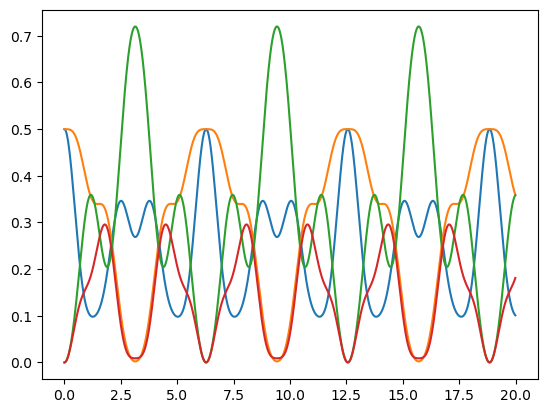

In [114]:
import matplotlib.pyplot as plt

t_list = np.arange(0, 20, dt)
results_qutip_sesolve = clevolve(esys, t_list, measure_populations=True)

P_qutip_s = results_qutip_sesolve.expect
error = [np.sqrt(P_qutip_s[i] * (np.ones_like(P_qutip_s[i]) - P_qutip_s[i]) / shots)
         for i in range(len(epsilon))]

[plt.plot(t_list, P_qutip_s[i]) for i in range(len(epsilon))]

**Dynamics with dephasing environment**

The evolution has been completed.


[[<matplotlib.lines.Line2D at 0x7faa5294cd90>],

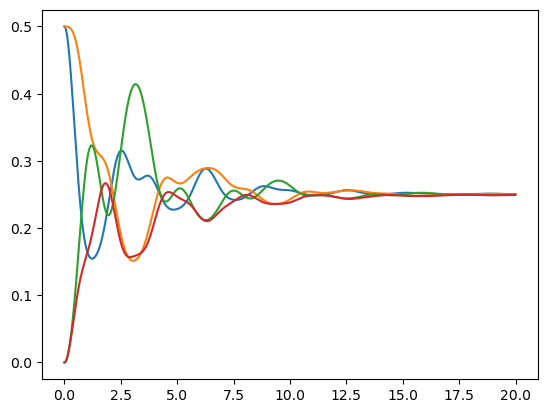

In [115]:
gamma = 0.1

t_list = np.arange(0, 20, dt)
results_qutip_mesolve = clevolve(esys, t_list, gamma, measure_populations=True)

P_qutip_m = results_qutip_mesolve.expect
error = [np.sqrt(P_qutip_m[i] * (np.ones_like(P_qutip_m[i]) - P_qutip_m[i]) / shots)
         for i in range(len(epsilon))]

[plt.plot(t_list, P_qutip_m[i]) for i in range(len(epsilon))]

**Chromophore test**

In [116]:
from scipy.linalg import toeplitz

epsilon = [1, 2]
J = toeplitz([0., 1.])

esys = ExcitonicSystem(energies=epsilon, couplings=J)
esys.set_state(state_type='localized excitation', state=0)

sys = ChromophoreSystem(excitonic_system=esys)
frequencies_pseudomode = [0]
Gamma = [2]
Omega = [1]

sys.pseudomodes(frequencies_pseudomode=frequencies_pseudomode,
                levels_pseudomode=[2]*len(frequencies_pseudomode),
                couplings_ep=np.sqrt(
                    np.array(Gamma)*np.array(Omega)/2).tolist(),
                )

sys.get_ep_Hamiltonian()

/tmp/ipykernel_3405/426889010.py:73: UserWarning: Equal dipole moments are assumed for all chromophores
  warnings.warn(


Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]

In [117]:
sys.get_global_Hamiltonian()

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  1.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.  -0.5  0.   0.   0.   1.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  1.   0.   0.   1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.  -0.5  0.   0.   0.   1.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.   0.   0.   0.   0.5  0.   1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0.   0.5  0.   1.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   1.

In [120]:
dt = 0.01
time = np.arange(0, 20, dt*100)
shots = 8000

t_list = np.arange(0, 20, dt)
results_qutip = clevolve(sys, t_list, measure_populations=True)

P_qutip = results_qutip.expect
error = []
for i in range(len(epsilon)):
    error.append(
        np.sqrt(P_qutip[i] * (np.ones_like(P_qutip[i]) - P_qutip[i]) / shots))

The evolution has been completed.
None


AttributeError: 'NoneType' object has no attribute 'expect'